# Проект: Прогнозирование вероятности оттока пользователей для фитнес-центров

**Оглавление**<a id="table_of_content"></a>
1. [Описание проекта](#chapter_1)
2. [Загрузка данных](#chapter_2)
3. [Исследовательский анализ данных](#chapter_3)
 1. [Общий обзор датасета](#chapter_3_1)
 2. [Анализ данных в колонках](#chapter_3_2)
 3. [Анализ групп ушедших и оставшихся клиентов](#chapter_3_3)
 4. [Анализ распределения признаков по групп](#chapter_3_4)
4. [Модель прогнозирования оттока клиентов](#chapter_4)
5. [Кластеризация клиентов](#chapter_5)
6. [Выводы](#chapter_6)

<a id="chapter_1"></a>
## Описание проекта

Целью проекта явлется выявление вероятности оттока каждого клиента фитнес-клуба на основании данных анкетирования для последующей работы по удержанию клиента.

Задачами проекта являются:
* выявление вероятности оттока клиентов
* формирование типичных портретов клиентов
* выявление факторов, влияющих на отток клиентов
* разрабока рекомендаций по удержанию клиентов:
 * обозначение целевых групп
 * разработка мер по снижению оттока
 * определение особенностей взаимодействия с клиентами

[к оглавлению](#table_of_content)

<a id="chapter_2"></a>
## Загрузка данных

In [ ]:
# подключение необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


# определение констант
PATH = '/datasets/gym_churn.csv'

# настройки графики
sns.set_theme(style='whitegrid')

# прочие настройки
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
data = pd.read_csv(PATH)
data.columns = data.columns.str.lower()  # приводим названия столбцов к snake case
data.head(5).T  # выводим первые пяти строк, чтобы удостовериться в корректности загрузки

,0,1,2,3,4
gender,1.00,0.00,0.00,0.00,1.00
near_location,1.00,1.00,1.00,1.00,1.00
partner,1.00,0.00,1.00,1.00,1.00
promo_friends,1.00,0.00,0.00,1.00,1.00
phone,0.00,1.00,1.00,1.00,1.00
contract_period,6.00,12.00,1.00,12.00,1.00
group_visits,1.00,1.00,0.00,1.00,0.00
age,29.00,31.00,28.00,33.00,26.00
avg_additional_charges_total,14.23,113.20,129.45,62.67,198.36
month_to_end_contract,5.00,12.00,1.00,12.00,1.00


Из описания данных:
* `gender` - пол
* `near_location` - проживание или работа в районе, где находится фитнес-центр
* `partner` - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента)
* `promo_friends` - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* `phone` - наличие контактного телефона
* `age` - возраст
* `lifetime` - время с момента первого обращения в фитнес-центр (в месяцах)
* `contract_period` - длительность текущего действующего абонемента (месяц, 6 месяцев, год)
* `month_to_end_contract` - срок до окончания текущего действующего абонемента (в месяцах)
* `group_visits` - факт посещения групповых занятий
* `avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента
* `avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц
* `avg_additional_charges_total` - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
* `churn` - факт оттока в текущем месяце

[к оглавлению](#table_of_content)

<a id="chapter_3"></a>
## Исследовательский анализ данных

<a id="chapter_3_1"></a>
### Общий обзор датасета

In [ ]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


1. В представелнных данных 4000 записей и нет пропусков.
2. Данные представлены только числами, нет категориальных переменных.
3. Диапазоны признаков значительно различаются (например, бинарные признаки и сумма дополнительных услуг). Для алгоритмов логистической регрессии и случайного леса стандартизация не требуется, однако на этапе кластеризации она будет обязательной.

<a id="chapter_3_2"></a>
### Анализ данных в колонках

1. `gender` - 0 или 1; клиенты по половому признаку распределены поровну.
2. `near_location` - 0 или 1; 84% клиентов живут или работают в районе фитнес-центра.
3. `partner` - 0 или 1; примерно половина клиентов - представители компаний-партнёров.
4. `promo_friends` - 0 или 1; примерно 30% клиентов воспользовались реферальной программой.
5. `phone` - 0 или 1; примерно 90% клиентов оставили контактный телефон.

In [ ]:
data.value_counts('contract_period', normalize=True)

contract_period
1    0.55
12   0.24
6    0.21
dtype: float64

6. `contract_period` - 1, 6 или 12;  55% клиентов имеют абонемент на 1 месяц, 24% клиентов владеют абонементом на год, 21% - на полгода.
7. `group_visits` - 0 или 1; 41% клиентов посещали групповые занятия.
8. `age` - от 18 до 41 года, в среднем 29 лет со стандартным отклонением 3 года.

9. `avg_additional_charges_total` - в среднем клиенты тратят на дополнительные услуги 147 у.е. со стандартным отклонением 96 у.е. Так как максимум составляет 552 у.е., а медиана (136 у.е.) и среденее примерно равны, то можно считать, что большинство клиентов не имеют значительных затрат на дополнительные услуги.

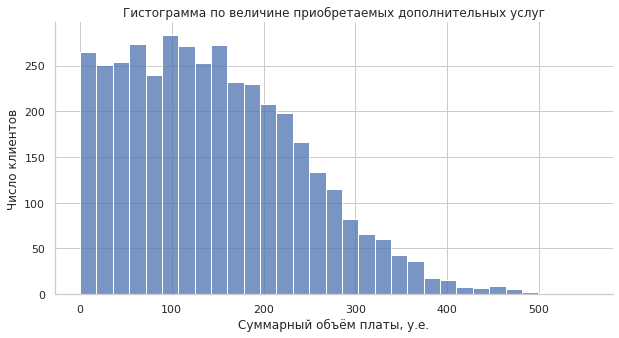

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
sns.histplot(x=data['avg_additional_charges_total'])
ax.set_title('Гистограмма по величине приобретаемых дополнительных услуг')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Суммарный объём платы, у.е.')
plt.show()

10. `month_to_end_contract` - так как расчёт ведётся в месяцах, то большинство клиентов имеют срок 1 месяц, также большое количество клиентов со сроком 6 и 12 месяцев, что выглядит странно. Скорее всего, прошла какая-то акция и многие абонементы свежекуплены.

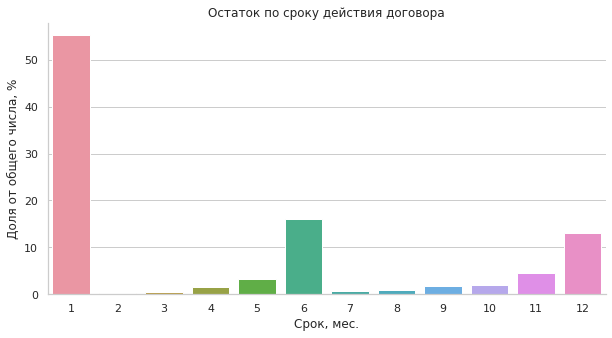

In [ ]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype("int")
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
data_to_plot = data.value_counts('month_to_end_contract', normalize=True) * 100
sns.barplot(x=data_to_plot.index,
            y=data_to_plot,
            orient='v')
ax.set_title('Остаток по сроку действия договора')
ax.set_ylabel('Доля от общего числа, %')
ax.set_xlabel('Срок, мес.')
plt.show()

11. `lifetime` - составляет от 0 до 31 месяца, для большинства клиентов срок посещения 3-4 месяца.

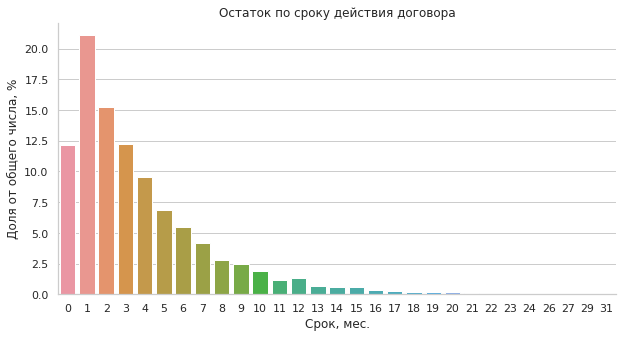

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
data_to_plot = data.value_counts('lifetime', normalize=True) * 100
sns.barplot(x=data_to_plot.index,
            y=data_to_plot,
            orient='v')
ax.set_title('Остаток по сроку действия договора')
ax.set_ylabel('Доля от общего числа, %')
ax.set_xlabel('Срок, мес.')
plt.show()

12. `avg_class_frequency_total` - в среднем клиенты посещают зал 1.9 раза в неделю, большинство ходит от 1 до 3 раз.

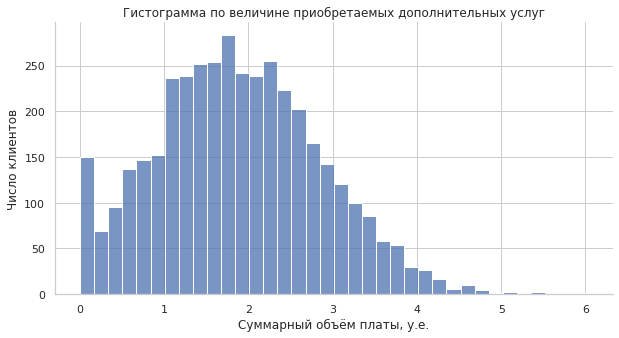

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
sns.histplot(x=data['avg_class_frequency_total'])
ax.set_title('Гистограмма по величине приобретаемых дополнительных услуг')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Суммарный объём платы, у.е.')
plt.show()

13. `avg_class_frequency_current_month` - в среднем клиенты за последний месяц посещают зал немного реже, чем обычно - 1.8 раза в неделю, большинство также ходит от 1 до 3 раз.

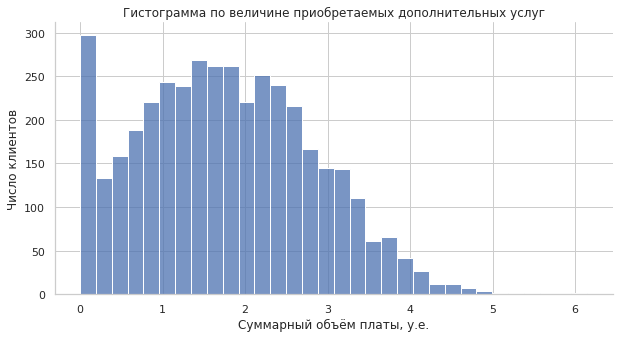

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
sns.histplot(x=data['avg_class_frequency_current_month'])
ax.set_title('Гистограмма по величине приобретаемых дополнительных услуг')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Суммарный объём платы, у.е.')
plt.show()

14. `churn` - 0 или 1; факт оттока составил 27%.

<a id="chapter_3_3"></a>
### Анализ групп ушедших и оставшихся клиентов

In [ ]:
data.groupby('churn').mean().T.rename(columns={0:'stay',
                                               1:'leave'})

churn,stay,leave
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Из групп можно сделать предварительный портрет клиента из группы оттока:
1. Не относится к компании-партнёру.
2. Не пользовался реферальной программой.
3. Имеет месячный абонемент.
4. Не посещает групповые программы.
5. Приобретает дополнительные услуги в небольшом объёме.
6. Посещает зал всего месяц.
7. Ходит менее 2-х раз в неделю.


Можно предположить, что это две группы клиентов:
1. Большинство - купившие месячный абонемент "на пробу" и забросившие зал.
2. Меньшая часть - клиенты, переставшие посещать зал по тем или иным причинам.

<a id="chapter_3_4"></a>
### Анализ распределения признаков по группам

In [ ]:
# функция для вывода графиков по бинарным значениям
def binary_figure(dt, gr_cols):  # принимает на вход DataFrame и словарь "имя столбца"-"наименование оси х"
    for col_name, x_label in gr_cols.items():
        ax = sns.catplot(data=dt.groupby(col_name, as_index=False)['churn'].mean(),
                    kind='bar',
                    x=col_name,
                    y='churn',
                    height=6,
                    aspect= 1,)
        ax.set_axis_labels(x_label, 'Доля оттока')
        plt.show()

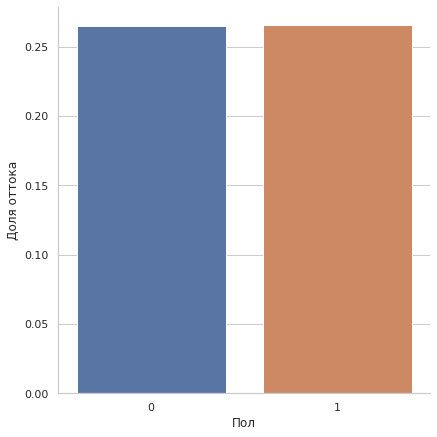

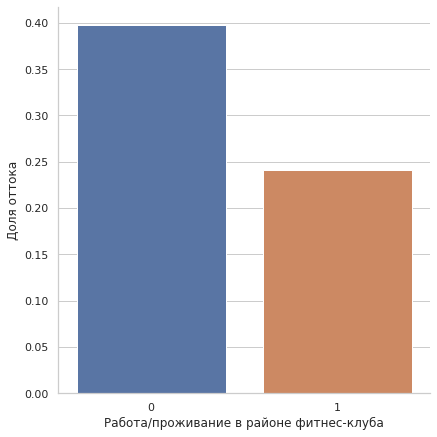

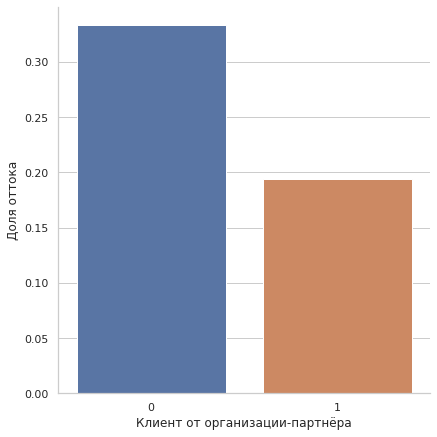

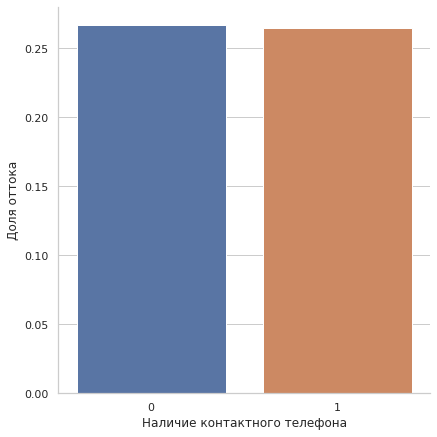

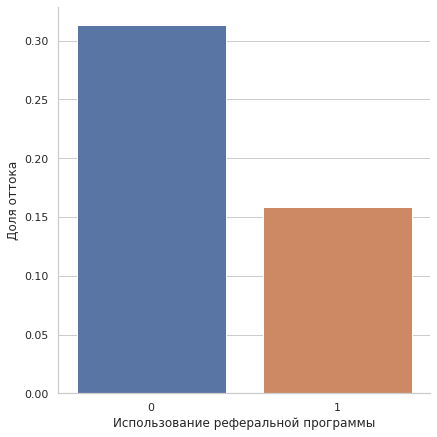

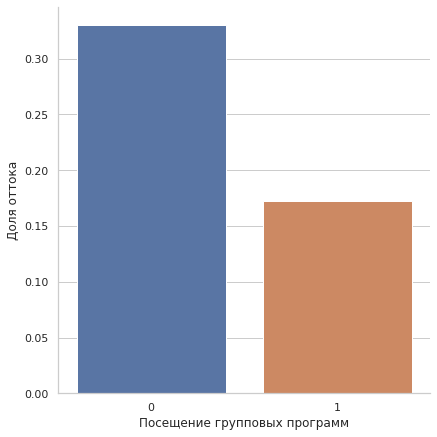

In [ ]:
binary_figure(data,
              {'gender': 'Пол',
               'near_location': 'Работа/проживание в районе фитнес-клуба',
               'partner': 'Клиент от организации-партнёра',
               'phone': 'Наличие контактного телефона',
               'promo_friends': 'Использование реферальной программы',
               'group_visits': 'Посещение групповых программ',})

**Промежуточные выводы**

1. Пол и наличие контактного никак не влияют на отток клиентов
2. Среди клиентов, посещавших групповые программы, пришедших по реферальным программам или от партнёров, а также работающих/проживающих в районе фитнес-центра доля оттока в два раза меньше.

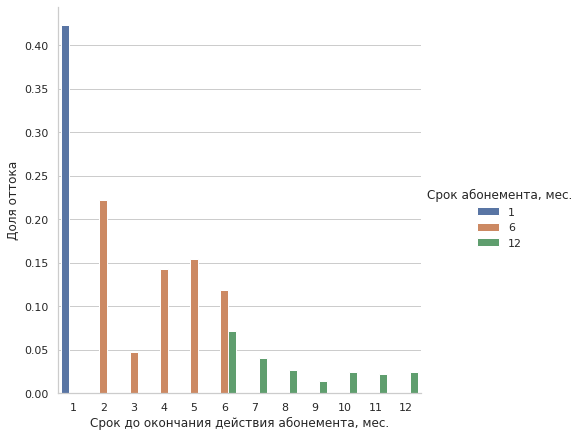

In [ ]:
ax = sns.catplot(data=data.groupby(['contract_period', 'month_to_end_contract'], as_index=False)['churn'].mean(),
                 kind='bar',
                 x='month_to_end_contract',
                 y='churn',
                 hue='contract_period',
                 height=6,
                 aspect= 1,
                 legend=False)
ax.add_legend(title='Срок абонемента, мес.')                 
ax.set_axis_labels('Срок до окончания действия абонемента, мес.', 'Доля оттока')
plt.show()

**Промежуточные выводы**

1. Чем больше срок абонемента, тем меньше вероятность оттока клиента - клиенту жаль потраченных средств.
2. С уменьшением срока, оставшегося по договору, вероятность оттока увеличивается.

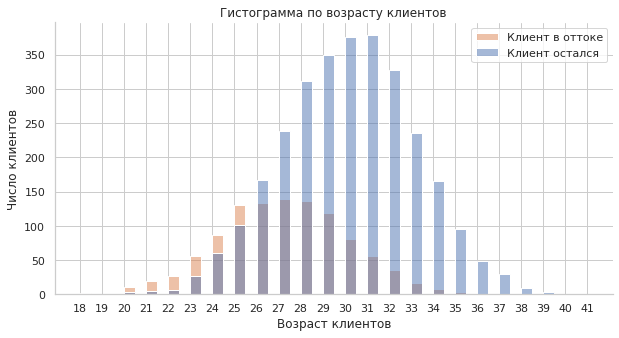

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
ax = sns.histplot(data=data,
             x='age',
             hue='churn',
             legend=False,)
ax.set_title('Гистограмма по возрасту клиентов')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Возраст клиентов')
ax.set_xticks([x for x in range(18, 42)])
plt.legend(title='', labels=['Клиент в оттоке', 'Клиент остался'])
plt.show()

**Промежуточный вывод**

Уходит большая часть клиентов в возрасте до 25 лет, начиная c 26 лет процент отток снижается, после 35 лет среди клиентов оттока практически нет.

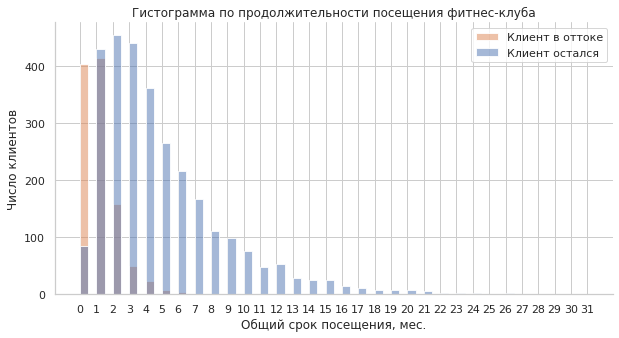

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
ax = sns.histplot(data=data,
             x='lifetime',
             hue='churn',
             legend=False,)
ax.set_title('Гистограмма по продолжительности посещения фитнес-клуба')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Общий срок посещения, мес.')
ax.set_xticks([x for x in range(32)])
plt.legend(title='', labels=['Клиент в оттоке', 'Клиент остался'])
plt.show()

**Промежуточный вывод**

Клиенты, посещавшие фитнес-клуб более 4 месяцев, практически не попадают в отток. Видимо, им всё нравится.

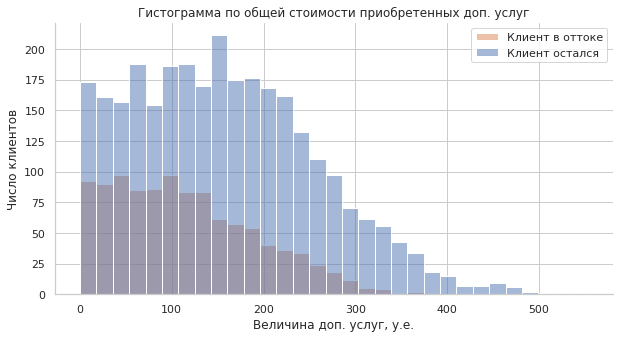

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
ax = sns.histplot(data=data,
             x='avg_additional_charges_total',
             hue='churn',
             legend=False,)
ax.set_title('Гистограмма по общей стоимости приобретенных доп. услуг')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Величина доп. услуг, у.е.')
plt.legend(title='', labels=['Клиент в оттоке', 'Клиент остался'])
plt.show()

**Промежуточный вывод**

Чем больше клиент приобретает дополнительных услуг начиная с суммы в 150 у.е., тем меньше вероятность оттока. Абсолютное большинство клиентов, потративших на дополнительные услуги более 300 у.е., остаются в клубе.

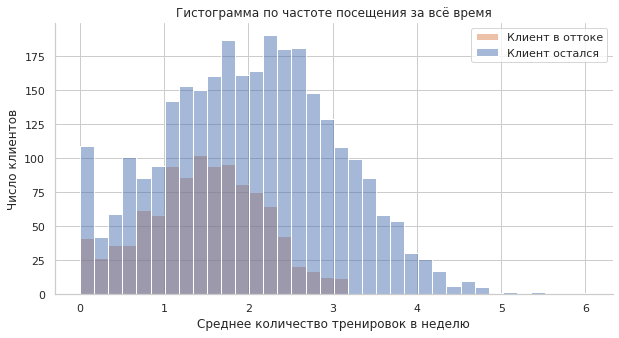

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
ax = sns.histplot(data=data,
             x='avg_class_frequency_total',
             hue='churn',
             legend=False,)
ax.set_title('Гистограмма по частоте посещения за всё время')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Среднее количество тренировок в неделю')
plt.legend(title='', labels=['Клиент в оттоке', 'Клиент остался'])
plt.show()

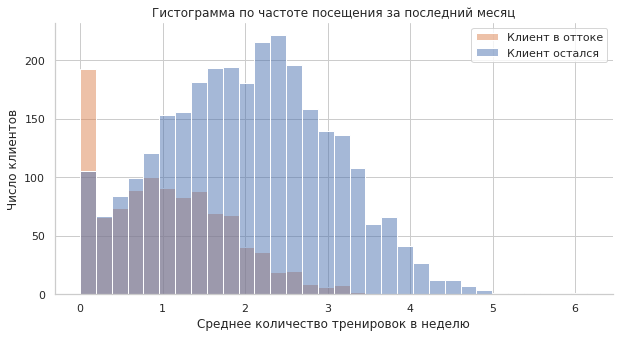

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(fig)
ax = sns.histplot(data=data,
             x='avg_class_frequency_current_month',
             hue='churn',
             legend=False,)
ax.set_title('Гистограмма по частоте посещения за последний месяц')
ax.set_ylabel('Число клиентов')
ax.set_xlabel('Среднее количество тренировок в неделю')
plt.legend(title='', labels=['Клиент в оттоке', 'Клиент остался'])
plt.show()

**Промежуточный вывод**

Более склонны к оттоку клиенты, тренирующиеся менее 2 раз в неделю.

In [ ]:
data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


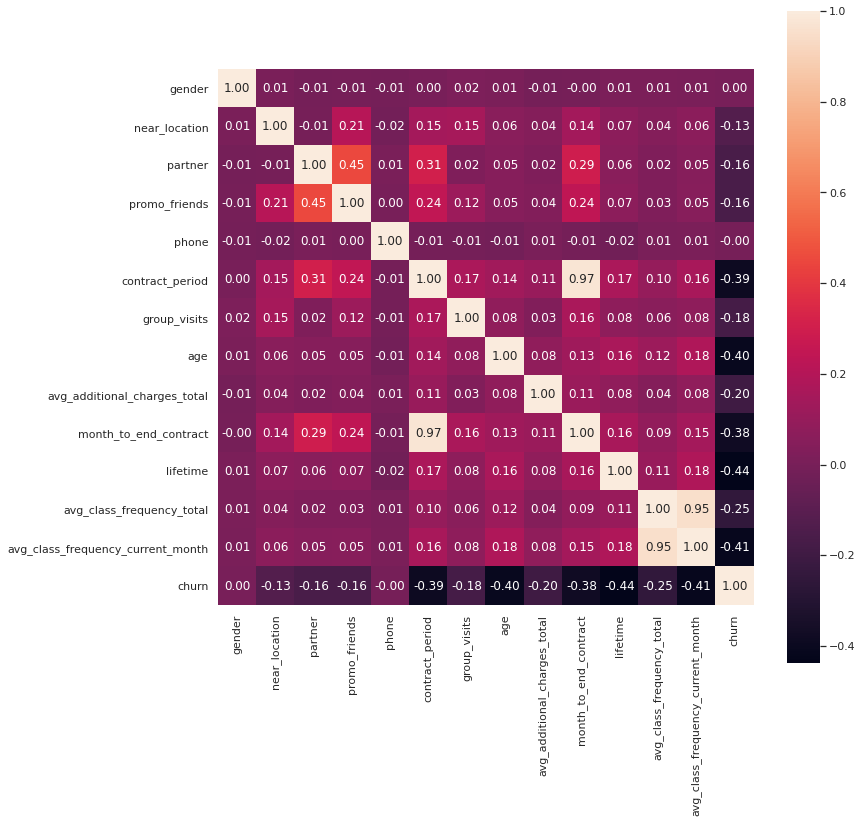

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data.corr(), fmt='.2f', annot=True, square=True)
plt.show()

**Промежуточный вывод**
1. Сильно скоррелированы между собой:
 1. Средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц, что логично, если в последнем месяце в жизни клиента или клуба не было каких то значительных изменений.
 2. Срок действия абонемента и остаток по сроку действия абонемента.
2. По сути в модели присутствует мультиколлинеарность, необходимо её устранить. Вручную удалим следующие признаки:
 1. Средняя частота посещений в неделю за предыдущий месяц
 2. Срок действия абонемента

In [ ]:
data = data.drop(['avg_class_frequency_current_month', 'contract_period'], axis=1)

[к оглавлению](#table_of_content)

<a id="chapter_4"></a>
## Модель прогнозирования оттока клиентов

In [ ]:
# выполним разделение на признаки и целевые значения
X = data.drop('churn', axis=1)
y = data['churn']
# выполним разбивку на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test =  train_test_split(X,
                                                     y,
                                                     test_size=0.3,
                                                     random_state=0,
                                                     stratify=y,)

In [ ]:
def predictor(model, X_trn, X_tst, y_trn, y_tst):
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    y_probas = model.predict_proba(X_tst)[:,1]
    # баланс классов
    print(f'Accuracy: {accuracy_score(y_tst, y_pred):.2f}')
    print(f'Precision: {precision_score(y_tst, y_pred):.2f}')
    print(f'Recall: {recall_score(y_tst, y_pred):.2f}')
    print(f'ROC AUC: {roc_auc_score(y_tst, y_probas):.2f}')

In [ ]:
lr_model = LogisticRegression(solver='liblinear',
                              random_state=0)
print("Метрики для модели, основанной на логистической регрессии:")
predictor(lr_model,
          X_train,
          X_test,
          y_train,
          y_test,)

Метрики для модели, основанной на логистической регрессии:
Accuracy: 0.89
Precision: 0.79
Recall: 0.77
ROC AUC: 0.95


In [ ]:
for _ in range(len(X.columns)):
    print(f'{X.columns[_]}: {lr_model.coef_[0][_]:.3f}')

gender: 0.102
near_location: 0.042
partner: -0.017
promo_friends: -0.274
phone: 0.076
group_visits: -0.670
age: -0.211
avg_additional_charges_total: -0.005
month_to_end_contract: -0.301
lifetime: -0.940
avg_class_frequency_total: -0.574


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0)
print("Метрики для модели, на основе случайного леса:")
predictor(rf_model,
          X_train,
          X_test,
          y_train,
          y_test,)

Метрики для модели, на основе случайного леса:
Accuracy: 0.87
Precision: 0.78
Recall: 0.73
ROC AUC: 0.94


**Промежуточный вывод**

1. Модели показали сопоставимые метрики
2. Метрика accuracy не является репрезентативной из-за отсутствия баланса классов
3. Метрика precision показывает более высокое значение для модели Случайного леса, в свою очередь метрика recall лучше для модели логистической регрессии.
4. Для нас важно не упускать клиентов, поэтому примем за более значимую метрику recall, и модель логистической регрессии с задачей справляется лучше.
5. Наибольшие веса в модели, основанной на логистической регрессии, имеют признаки:
 1. Продолжительность посещения фитнес-клуба
 2. Посещение групповых программ
 3. Средняя частота посещения фитнес-клуба
 4. Срок до окончания действия абонемента
 5. Участие по реферальной программе
 6. Возраст клиента

[к оглавлению](#table_of_content)

In [ ]:
def custom_predictor(model, X_trn, X_tst, y_trn, y_tst, threshold):
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    y_probas = model.predict_proba(X_tst)[:,1]
    custom_y_pred = [0 if i < threshold else 1 for i in y_probas]
    # баланс классов
    print(f'Accuracy: {accuracy_score(y_tst, custom_y_pred):.2f}')
    print(f'Precision: {precision_score(y_tst, custom_y_pred):.2f}')
    print(f'Recall: {recall_score(y_tst, custom_y_pred):.2f}')
    print(f'ROC AUC: {roc_auc_score(y_tst, y_probas):.2f}')

In [ ]:
lr_model = LogisticRegression(solver='liblinear',
                              random_state=0)
print("Метрики для модели, основанной на логистической регрессии:")
custom_predictor(lr_model,
                 X_train,
                 X_test,
                 y_train,
                 y_test,
                 0.3,)

Метрики для модели, основанной на логистической регрессии:
Accuracy: 0.88
Precision: 0.71
Recall: 0.91
ROC AUC: 0.95


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0)
print("Метрики для модели, на основе случайного леса:")
custom_predictor(rf_model,
                 X_train,
                 X_test,
                 y_train,
                 y_test,
                 0.3,)

Метрики для модели, на основе случайного леса:
Accuracy: 0.88
Precision: 0.72
Recall: 0.89
ROC AUC: 0.94


**Промежуточный вывод**

Попытка учесть несбалансированность выборки путём установки кастомного порога позволила повысить метрику recall до 0.91 за счёт ухудшения метрики precision. В нашем случае главное не упустить клиента, поэтому ориентируемся на метрику recall.

In [ ]:
# стандартизация данных
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [ ]:
X_test_st=scaler.transform(X_test)

In [ ]:
lr_model = LogisticRegression(solver='liblinear',
                              random_state=0)
print("Метрики для модели, основанной на логистической регрессии:")
custom_predictor(lr_model,
          X_train_st,
          X_test_st,
          y_train,
          y_test,
          0.3,)

Метрики для модели, основанной на логистической регрессии:
Accuracy: 0.88
Precision: 0.72
Recall: 0.89
ROC AUC: 0.95


In [ ]:
for _ in range(len(X.columns)):
    print(f'{X.columns[_]}: {lr_model.coef_[0][_]:.3f}')

gender: 0.019
near_location: -0.079
partner: -0.079
promo_friends: -0.121
phone: -0.133
group_visits: -0.383
age: -1.207
avg_additional_charges_total: -0.580
month_to_end_contract: -1.353
lifetime: -3.739
avg_class_frequency_total: -0.691


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0)
print("Метрики для модели, на основе случайного леса:")
custom_predictor(rf_model,
                 X_train_st,
                 X_test_st,
                 y_train,
                 y_test,
                 0.3,)

Метрики для модели, на основе случайного леса:
Accuracy: 0.88
Precision: 0.73
Recall: 0.88
ROC AUC: 0.94


**Дополнительные выводы**
1. Стандартизация не оказала значительного влияния на эффективность моделей. Модель логистической регрессии показывает большую точность для заданных условий.
2. Изменились веса признаков, после стандартизации самыми значимыми признаками являются:
    1. Общее время посещения фитнес-клуба
    2. Срок до окончания действия абонемента
    3. Возраст клиента
    4. Средняя частота посещения клуба
    5. Объём приобретаемых дополнительных услуг
    6. Посещение групповых программ

<a id="chapter_5"></a>
## Кластеризация клиентов

In [ ]:
# стандартизация данных
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

In [ ]:
linked = linkage(X_st, method = 'ward')

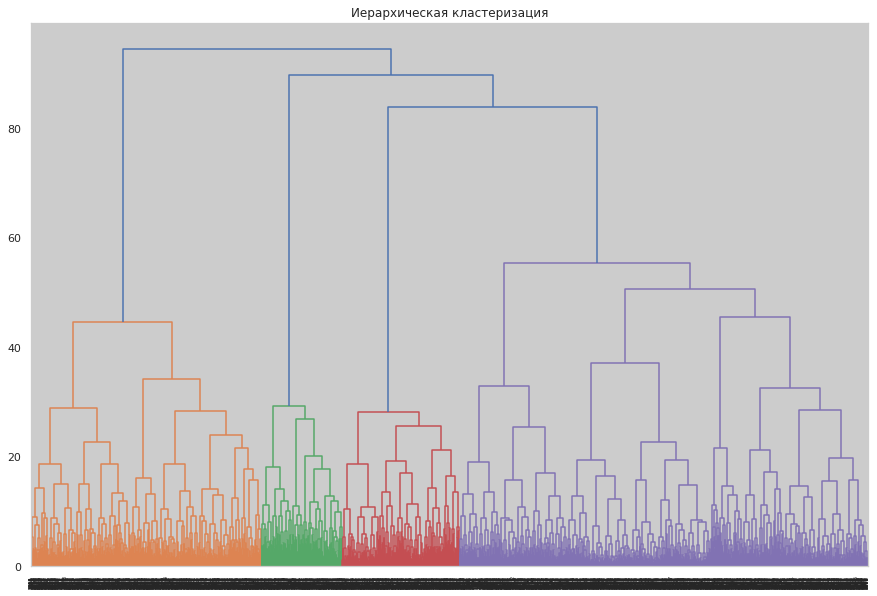

In [ ]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

**Промежуточный вывод**

По результатам кластеризации можно выделить от 4 до 7 кластеров. В рамках дальнейшего исследования примем 5 клатеров.

In [ ]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)

In [ ]:
data.groupby(labels)['age'].count()

0    1001
1     557
2     898
3    1158
4     386
Name: age, dtype: int64

In [ ]:
data.groupby(labels).mean().T

,0,1,2,3,4
gender,0.50,0.50,0.52,0.51,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.42,0.20,0.47
promo_friends,1.00,0.08,0.01,0.05,0.31
phone,1.00,1.00,1.00,1.00,0.00
group_visits,0.52,0.23,0.55,0.30,0.43
age,29.54,28.69,30.81,27.82,29.30
avg_additional_charges_total,152.14,137.28,177.10,124.63,144.21
month_to_end_contract,6.27,2.80,6.16,1.90,4.47
lifetime,4.21,2.98,5.70,2.06,3.94


**Промежуточные выводы**
1. Группами с наименьшим оттоком являются 0 и 2.
2. Наихудшие по оттоку группы 1 и 3 и 4.

In [ ]:
data['label'] = labels

In [ ]:
# функция для вывода графиков по бинарным значениям
def binary_figure(dt, gr_cols):  # принимает на вход DataFrame и словарь "имя столбца"-"наименование оси х"
    for col_name, x_label in gr_cols.items():
        ax = sns.catplot(data=dt.groupby('label', as_index=False)[col_name].mean(),
                    kind='bar',
                    x='label',
                    y=col_name,
                    height=6,
                    aspect= 1,)
        ax.set_axis_labels('Группы клиентов', x_label)
        plt.show()

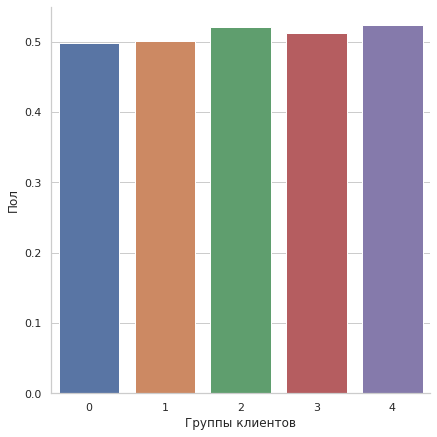

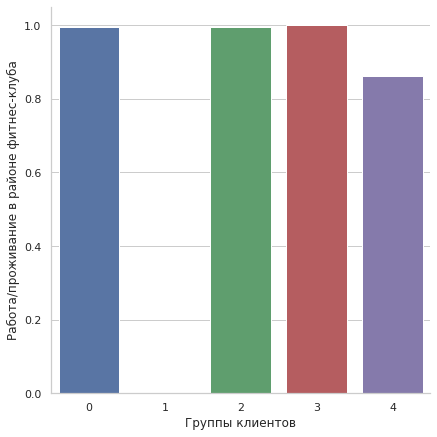

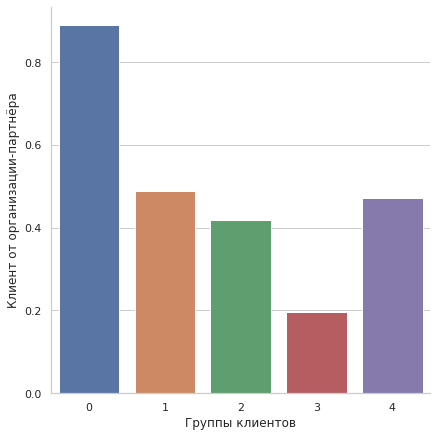

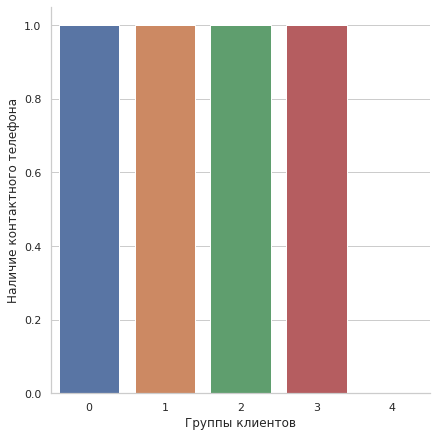

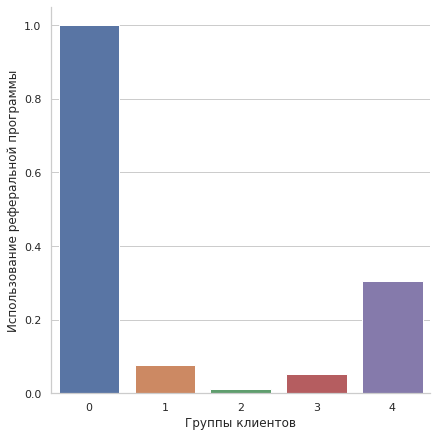

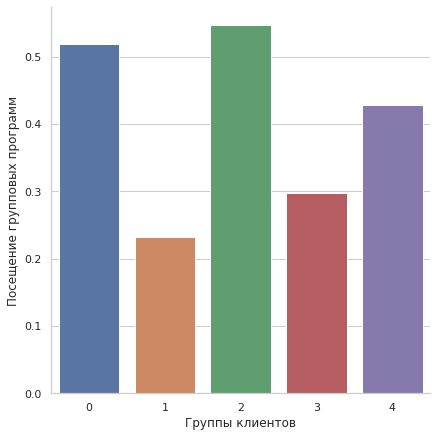

In [ ]:
binary_figure(data,
              {'gender': 'Пол',
               'near_location': 'Работа/проживание в районе фитнес-клуба',
               'partner': 'Клиент от организации-партнёра',
               'phone': 'Наличие контактного телефона',
               'promo_friends': 'Использование реферальной программы',
               'group_visits': 'Посещение групповых программ',})

**Промежуточные выводы**
1. Распределение по полу никак не влияет на выбор групп.
2. Группа 1 практически полностью охватывает клиентов, проживающих/работающих не в районе фитнес-клуба.
3. Большая часть группы 0 представляют собой клиентов от организации-партнёра, при этом данный признак также представлен во всех группах.
4. Группа 4 представляет собой клиентов, не оставивших контактный телефон.
5. Группа 0 объединяет большинство клиентов, воспользовавшихся реферальной программой.
6. Признак посещение групповых программ присутствует во всех группах, хотя наиболее представлен в группах 0 и 2.

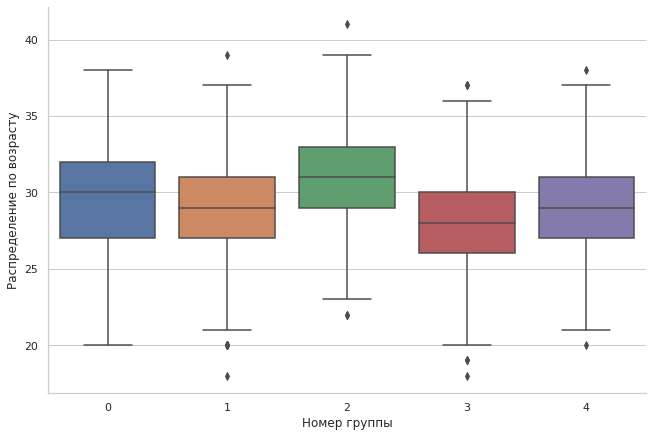

In [ ]:
ax = sns.catplot(data=data,
                 kind='box',
                 x='label',
                 y='age',
                 height=6,
                 aspect= 1.5)          
ax.set_axis_labels('Номер группы', 'Распределение по возрасту')
plt.show()

**Промежуточные выводы**

Группы 1, 4 и особенно 3 представлены наиболее молодыми клиентами, по сравнению с группами 0 и 2.

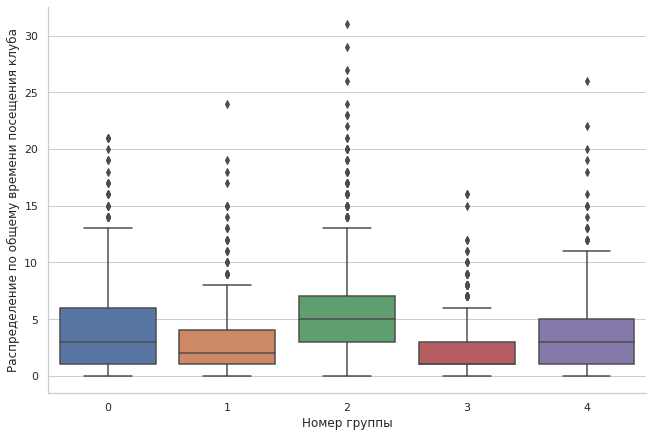

In [ ]:
ax = sns.catplot(data=data,
                 kind='box',
                 x='label',
                 y='lifetime',
                 height=6,
                 aspect= 1.5)          
ax.set_axis_labels('Номер группы', 'Распределение по общему времени посещения клуба')
plt.show()

**Промежуточные выводы**

1. Группа 2 выделяется по наибольшему среднему времени посещения клуба.
2. Группа 3 отличается наименьшим средним временем посещения клуба.

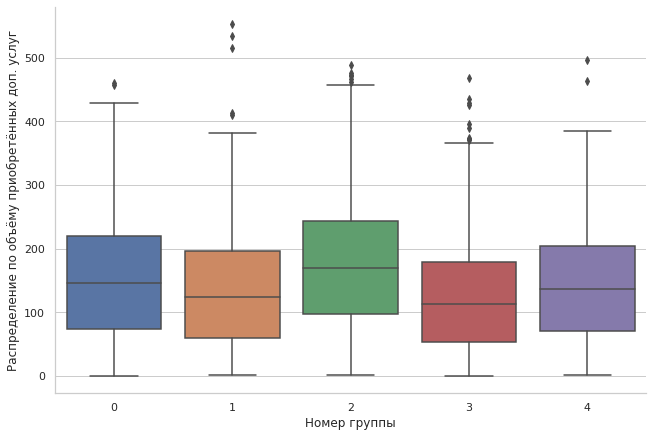

In [ ]:
ax = sns.catplot(data=data,
                 kind='box',
                 x='label',
                 y='avg_additional_charges_total',
                 height=6,
                 aspect= 1.5)          
ax.set_axis_labels('Номер группы', 'Распределение по объёму приобретённых доп. услуг')
plt.show()

**Промежуточные выводы**

1. Группа 3 выделяется наименьшим объёмом приобретенных допуслуг, хотя явных лидеров в данной категории нет.

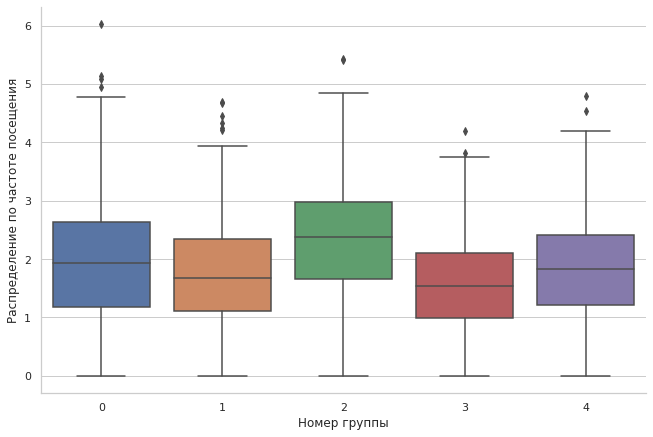

In [ ]:
ax = sns.catplot(data=data,
                 kind='box',
                 x='label',
                 y='avg_class_frequency_total',
                 height=6,
                 aspect= 1.5)          
ax.set_axis_labels('Номер группы', 'Распределение по частоте посещения')
plt.show()

**Промежуточные выводы**

1. Группы, склонные к оттоку, состоят из клиентов, которые посещяют зал менее 2 раз в неделю.

[к оглавлению](#table_of_content)

<a id="chapter_6"></a>
## Выводы

В рамках исследования был выполнен анализ данных клиентов фитнес-клуба с целью разработки рекомендаций для снижения оттока.
1. При первичном анализе данных было установлено следующее:
    1. Отток составляет 27%
    2. 84% клиентов живут или работают в районе фитнес-центра.
    3. Половины клиентов - представители компаний партнёров.
    4. 30% клиентов воспользовались реферальной программой.
    5. 90% клиентов оставили контактный телефон.
    6. 55% клиентов имеют абонемент на 1 месяц, 24% клиентов владеют абонементом на год, 21% - на полгода.
    7. 41% клиентов посещали групповые занятия.
    8. Возраст клиентов находится в диапазоне от 18 лет до 41 года, в среднем 29 лет +/- 3 года.


2. В рамках анализа была определена как наиболее удачная модель на основе логистической регрессии. Согласно данной модели наиболее значимыми факторами являются:
    1. Общее время посещения фитнес-клуба
    2. Срок до окончания действия абонемента
    3. Возраст клиента
    4. Средняя частота посещения клуба
    5. Объём приобретаемых дополнительных услуг
    6. Посещение групповых программ


3. При кластеризации клиентов было выделено 5 групп (от 0 до 4):
    1. Ключевое отличие 0 группы с оттоком 13% - участие в реферальных программах
    2. Ключевое отличие 1 группы с оттоком 40% - проживание/работа вне района фитнес-клуба
    3. Ключевое отличие 2 группы с оттоком 2% - возраст 30+, участие в групповых программах, большое количество тренировок. Скорее всего, это фанаты фитнес-клуба. Они приобретают наибольший объём дополнительных услуг.
    4. Ключевое отличие 3 группы с оттоком 51% - люди, пришедшие "со стороны" и с малым сроком действия абонемента. Скорее всего, заключают минимальный договор, чтобы разобраться, нравиться им или нет.
    5. Ключевое отличие 4 группы с оттоком 27% - отсутствие контактного телефона.
 
 
4. По результатам исследования можно сделать следующие выводы:
    1. Для удержания клиента важную роль играет наличие канала связи (возможно, необходимо периодически напоминать о преимуществах посещения фитнес-клуба, рассказывать о новых услугах и программах). Клиенты, оставившие телефон для контакта меньше подвержены оттоку.
    2. Рекомандуется развивать и поддерживать сеть компаний-партнёров и, особенно, продвигать реферальные программы, так как они приносят лояльных клиентов. Можно предположить, что наличие коллег/друзей/компании в зале мотивирует на повторные посещения.
    3. Рекомендуется привлекать клиентов к участию в групповых программах, так как они снижают отток клиентов. В наиболее лояльных группах около половины клиентов участвуют в групповых программах.
    4. Более лояльными оказываются клиенты возрастной группы от 30 до 41 года.
    5. Для людей, проживающих вне района фитнес-клуба, рекомендуется собрать контакты и пригласить их при открытии филиала в их районе.
    6. Необходимо "заботиться" о лояльных клиентах группы 3 с наименьшим оттоком: программы лояльности и т.п.
    7. Рекомендуется для группы 4 провести исследование по причинам оттока.


[к оглавлению](#table_of_content)